### Исследование популярных каналов онлайн трансляций

В качестве темы для проекта было выбрано исследование поведения пользователей на стриминговой платформе Twitch.tv. Имея небольшой бэкграунд в изучении этой сферы, я решила, что процесс подготовки работы может получиться полезным как для программирования, так и в исследовательском плане, а результаты могут оказаться интересными (и, возможно, даже полезными кому-нибудь).

### О чем идёт речь и какая цель у всего этого

Речь идёт о многообразии контента, которое временами усложняет поиск интересующей трансляции. Поскольку каналов с трансляциями на сервисе много, а разделения – относительно мало (~~и в дополнение к этому предсказание популярности уже изучалось очень многими~~), интересным оказался вопрос о том, можно ли уловить разницу в предлагаемом контенте по данным, лежащим буквально на поверхности. Сами же трансляции условно можно разделить на те, где присутствует стример, и те, где такового нет, но вместо этого показывают какие-либо соревнования/конференции/мультики/etc.

Собственно, целью проекта является выявление наличия/отсутствия паттернов, позволяющих нам отделить один тип каналов от другого.

### Хорошо, но в чём смысл?


На самом деле, это достаточно популярный (и в то же время сложный) вопрос, на который нет однозначного ответа. Тем не менее, в некоторых случаях его можно попытаться найти:

* Хоть польза подобных проектов сейчас подвергается критике, на деле же результаты таких исследований могут быть полезными в первую очередь создателям сервиса и их модераторам: так, модель, указывающая нам на медийный/любительский канал может быть не столько важна в плане "мы можем *предсказать* тип канала по данным с самого же канала", сколько "мы можем *узнать, какие фичи будут важны* нашим пользователям и что можно сделать для их (пользователей) дальнейшего удобства"; 

* С другой же стороны, результаты исследования могут быть интересны и социологам, поскольку они (результаты) могут показать, как зрители будут вести себя по отношению к более приближенным к традиционному медиа каналам и как, наоборот, к каналам более отдалённым от такого понятия.

Первую часть, а именно сбор данных, можно посмотреть по [следующей ссылке](https://xenak.github.io/python_proj_twitch/data/).

### Описание датасета

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
twitch=pd.read_csv('twitchdata.csv', sep=",") 

# Небольшая чистка данных
twitch=twitch.dropna()
twitch.drop(['Unnamed: 0','name'], axis = 1, inplace = True) # сразу уберём названия каналов, тк они нам не пригодятся
twitch['in_partnership']=twitch['in_partnership'].astype('object')
twitch['mature']=twitch['mature'].astype('object')

twitch.shape

(545, 11)

Таким образом, у нас в распоряжении сведения о 545 популярных каналах стримингового сервиса.

Переменные же можно описать следующим образом:
* **broadcasts_num** – количество трансляций, проведённых на канале
* **creation_year** – год основания канала
* **followers** – количество подписчиков
* **following** – количество каналов, на которые подписан пользователь
* **highlights_num** – количество "ярких моментов" на канале (как правило, вырезаются пользователем),
* **in_partnership** – есть/нет партнёрской программы (при наличии стример может получать доход с трансляций и подписок на канал)
* **language** – (основной) язык трансляции
* **mature** – есть ли на канале ограничение "18+"
* **teams** – в скольких командах состоит пользователь (т.е. в разных группах стримеров)
* **views** – количество просмотров канала
* **type** – тип канала: официальные трансляции (более сопоставимые с масс медиа) или же любительские трансляции от протстых пользователей. Значение присваивалось вручную после изучения каждого канала.

In [91]:
twitch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 11 columns):
broadcasts_num    545 non-null int64
creation_year     545 non-null int64
followers         545 non-null int64
following         545 non-null int64
highlights_num    545 non-null int64
in_partnership    545 non-null object
language          545 non-null object
mature            545 non-null object
teams             545 non-null int64
views             545 non-null int64
type              545 non-null object
dtypes: int64(7), object(4)
memory usage: 51.1+ KB


На данный момент, числовых переменных в датасете 7, в то время как категориальных – 4 (вместе с зависимой переменной). Поскольку каналы были отобраны из списка наиболее популярных, количество просмотров ('views') и подписчиков ('followers') преимущественно высоко, что очень хорошо показывает сам питон:

In [92]:
twitch.describe()

,broadcasts_num,creation_year,followers,following,highlights_num,teams,views
count,545.000000,545.000000,5.450000e+02,545.000000,545.000000,545.000000,5.450000e+02
mean,323.785321,2012.405505,5.557597e+05,117.878899,582.614679,1.491743,4.491988e+07
std,762.073470,2.018018,7.351695e+05,193.023239,1680.395746,1.965798,6.938919e+07
min,1.000000,2007.000000,3.825000e+03,0.000000,0.000000,0.000000,4.439930e+05
25%,38.000000,2011.000000,2.526430e+05,12.000000,17.000000,0.000000,1.506661e+07
50%,64.000000,2012.000000,3.978840e+05,48.000000,106.000000,1.000000,2.714798e+07
75%,195.000000,2014.000000,6.028200e+05,157.000000,527.000000,2.000000,4.678252e+07
max,9871.000000,2018.000000,1.193244e+07,1857.000000,26977.000000,13.000000,1.063934e+09


Сам же датасет выглядит следующим образом:

In [93]:
twitch.head()

,broadcasts_num,creation_year,followers,following,highlights_num,in_partnership,language,mature,teams,views,type
0,455,2011,11932442,247,247,True,en,False,1,356868818,person
1,871,2012,4672585,70,35,True,en,False,0,226014173,person
2,60,2015,4439377,168,106,True,en,True,2,62076447,person
3,66,2011,3320792,185,268,True,en,False,2,245213917,channel
4,100,2014,3266302,418,152,True,en,False,1,48294410,person


Он содержит две логические переменные, а также две категориальные (одна из них – зависимая). Это не очень здорово в данном случае (их (кроме зависимой) будет не так просто включить в модель), поэтому позднее нужно будет их перекодировать.

Переходя к описанию отдельных переменных, для начала необходимо рассмотреть зависимую переменную:

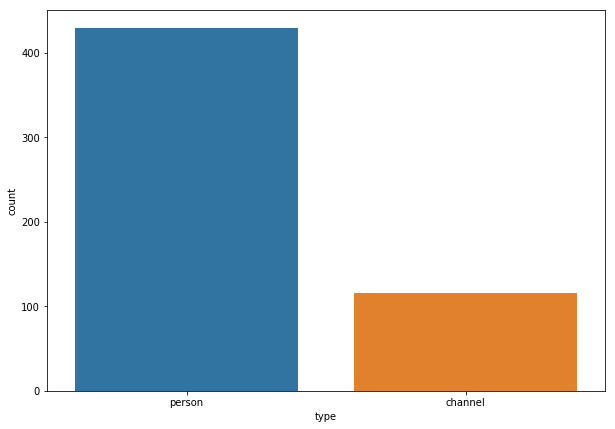

In [96]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x='type', data=twitch, ax=ax)

Чисто пропорционально количество каналов, принадлежащих индивидуальным стримерам, достаточно сильно превышает количество медийных каналов. Учитывая, что в настоящее время Twitch.tv является одной из наиболее популярных площадок для онлайн трансляций (и достаточно простой в обращении), это неудивительно: отдельно стримеры пользуются сервисом достаточно активно. 

Далее, можно взглянуть на категориальные переменные:

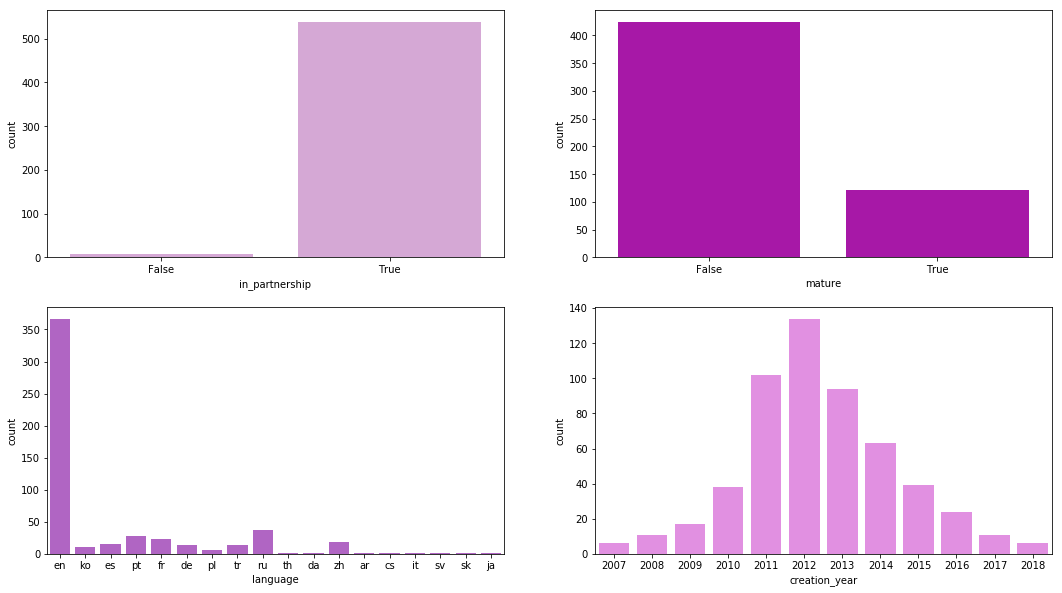

In [97]:
f, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.countplot(x='in_partnership', data=twitch, ax=axes[0, 0], color='plum')
sns.countplot(x='mature', data=twitch, ax=axes[0, 1], color='m')
sns.countplot(x='language', data=twitch, ax=axes[1, 0], color='mediumorchid')
sns.countplot(x='creation_year', data=twitch, ax=axes[1, 1],color='violet')

Отсюда можно извлечь несколько важных выводов:
1. Каналов без партнёрской программы очень мало; весьма сомнительно, что эти данные смогут внести хоть какой-нибудь вклад в дальнейшую модель;
2. С языками каналов тоже достаточно однозначная картина: большая часть популярных трансляций принадлежит англоговорящей аудитории;
3. Что касается "взрослости" контента и распределения каналов по году их основания, здесь мало шокирующих открытий. Большая часть каналов является family-friendly, а пик создания популярных на данный момент каналов пришёлся на 2012 год.

Если попытаться посмотреть на взаимосвязи всех переменных со всеми, получится слишком много информации. Тем не менее, здесь же можно обратить внимание на то, что особых связей не замечено (по крайней мере, наглядно):

C:\Users\xena\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


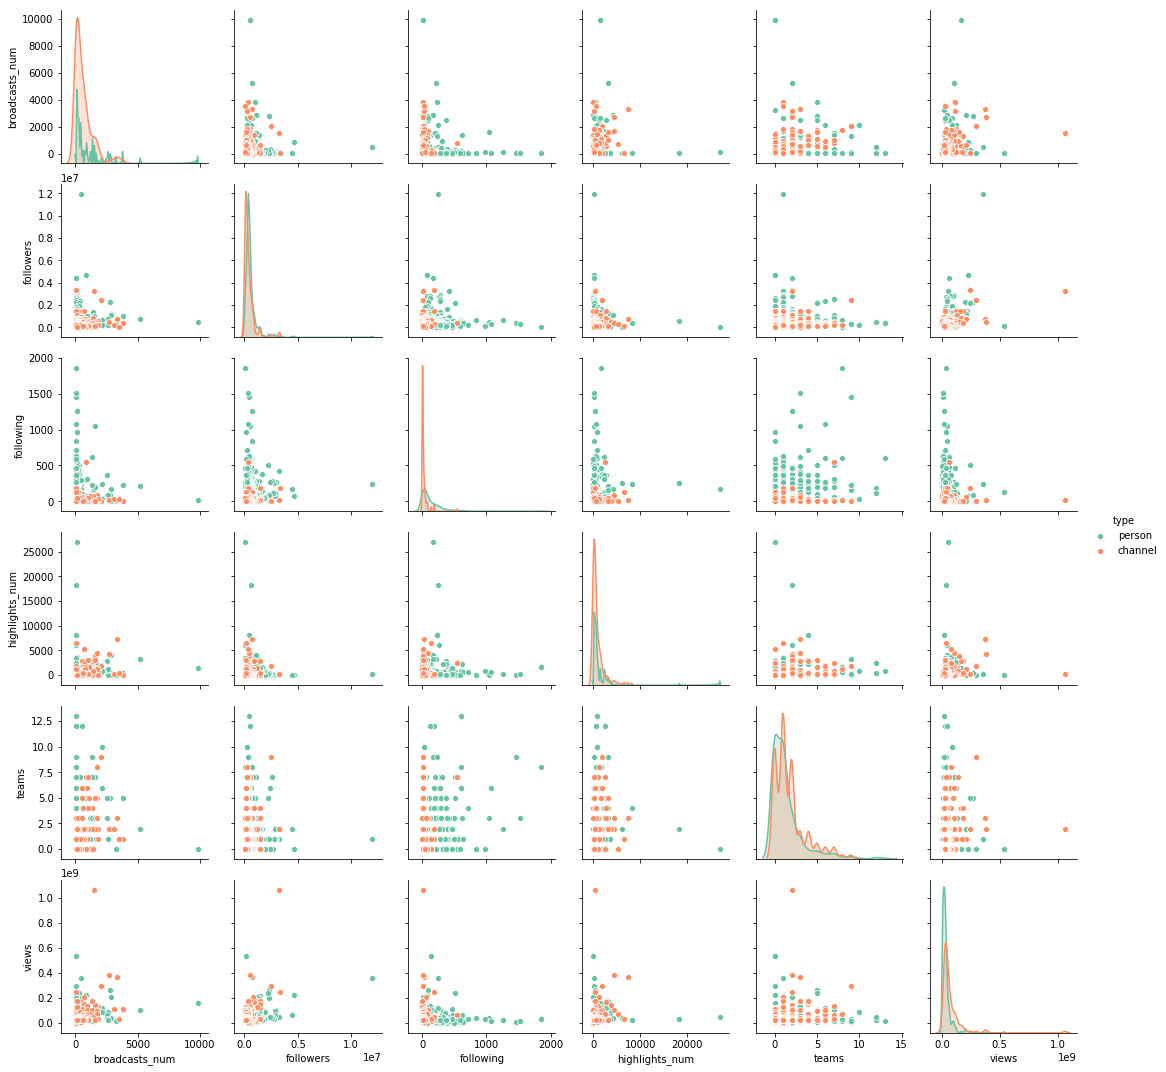

In [120]:
twitchpar=pd.read_csv('twitchdata.csv', sep=",") 
twitchpar=twitchpar.dropna()
twitchpar.drop(['Unnamed: 0','name','in_partnership','language','mature','creation_year'], axis = 1, inplace = True)
sns.pairplot(twitchpar, hue='type', palette='Set2')

Однако, посмотреть на некоторые взаимосвязи отдельно всё равно интересно:

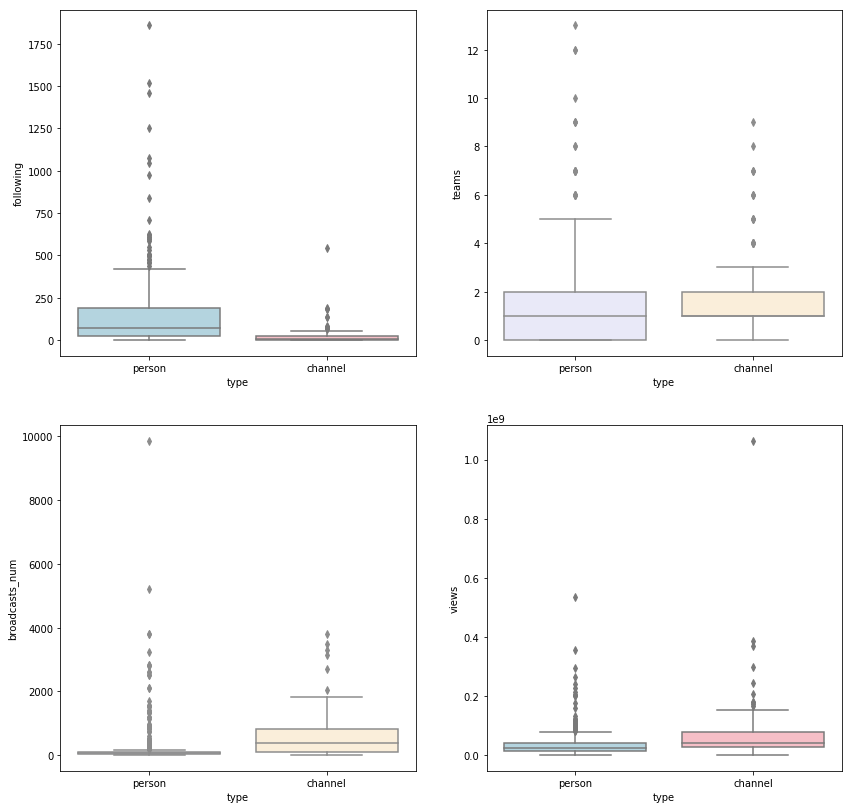

In [123]:
f, axes = plt.subplots(2, 2, figsize=(14, 14))

sns.boxplot("type", "following", data=twitch, ax=axes[0,0],
               palette=["lightblue", "lightpink"]);
sns.boxplot("type", "broadcasts_num", data=twitch, ax=axes[1,0],
               palette=["lavender", "papayawhip"]);
sns.boxplot("type", "teams", data=twitch, ax=axes[0,1],
               palette=["lavender", "papayawhip"]);
sns.boxplot("type", "views", data=twitch, ax=axes[1,1],
               palette=["lightblue", "lightpink"]);


Так, можно обратить внимание на то, что стримеры скорее всего будут фолловить больше каналов и сохранять меньше записей трансляций, чем владельцы медийных каналов, в то время как состояние в командах и количество просмотров хоть и будут в некоторых аспектах различаться, но не так драматично.

### Построение модели

Теперь можно переходить непосредственно к основной части работы – к построению модели.
Поскольку это финальный отчёт, смысла строить модели, которые получились сильно хуже, мало. В таком случае, важно сказать, что наиболее эффективной и интересной для интерпретации показалось дерево решений.

Для начала нужно разобраться с категориальными переменными (иначе дерево не захочет строиться):

In [106]:
twitch['language'] = np.where(twitch['language'] == 'en', 1, 0) # вспомним про пропорциональность данных в этой переменной
twitch['mature'] = pd.get_dummies(twitch['mature'])
twitch.drop(['in_partnership'], axis = 1, inplace = True)

Теперь можно непосредственно переходить к делу:

In [107]:
X = twitch.iloc[:, 0:9].values
y = twitch['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [108]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
twitch_pred_type = le.classes_

In [109]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [110]:
y_pred_tree = tree.predict(X_test)

print(classification_report(y_test, y_pred_tree, target_names=twitch_pred_type))

             precision    recall  f1-score   support

    channel       0.65      0.50      0.56        40
     person       0.87      0.92      0.89       142

avg / total       0.82      0.83      0.82       182



Судя по результатам, можно сказать, что модель вышла не такой уж и плохой.
В конкретном случае информация о количестве каналов того или иного типа может частично объяснить ситуацию: так вышло, что медийных каналов оказалось примерно в 3 раза меньше, чем обычных. Так, у модели выше вероятность ошибиться насчёт официальных каналов и отправить их к обычным стримерам (которых много, и все они разные).
Тем не менее, в целом же модель оказалась неплохой в предсказании:

In [114]:
cross_val_score(tree, X_train, y_train, cv=3).mean() # это если мы ещё и кросс-валидацию применим

0.8404397928615515

Но что же по вкладу переменных в модель?

In [118]:
twitch.columns[0:9] # для начала вспомним, какие переменные включены в модель

Index(['broadcasts_num', 'creation_year', 'followers', 'following',
       'highlights_num', 'language', 'mature', 'teams', 'views', 'type'],
      dtype='object')

In [115]:
tree.feature_importances_ # а потом посмотрим на оценки их важности

array([0.26646493, 0.03888972, 0.03728262, 0.47825973, 0.0397152 ,
       0.        , 0.        , 0.02874945, 0.11063836])

Интересно, что год создания канала всё-таки имеет достаточную силу для предсказания того, с каналом какого типа мы имеем дело. Наиболее же весомым критерием оказалось число подписок на другие каналы: если вспомнить часть с описательной статистикой, можно также предположить, что через медийные каналы подписываются реже, чем через обычные (что логично: обычные стримеры тоже смотрят трансляции). Возрастное ограничение и количество команд, к которым принадлежит канал, в свою очередь, несут наименьший вклад в модель (если он вообще есть).

### Визуализация дерева

In [75]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=twitch_pred_type,
                           feature_names=['broadcasts_num',
                                          'creation_year',
                                          'followers',
                                          'following',
                                          'highlights_num',
                                          'language',
                                          'mature',
                                          'teams',
                                         'views'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')



True

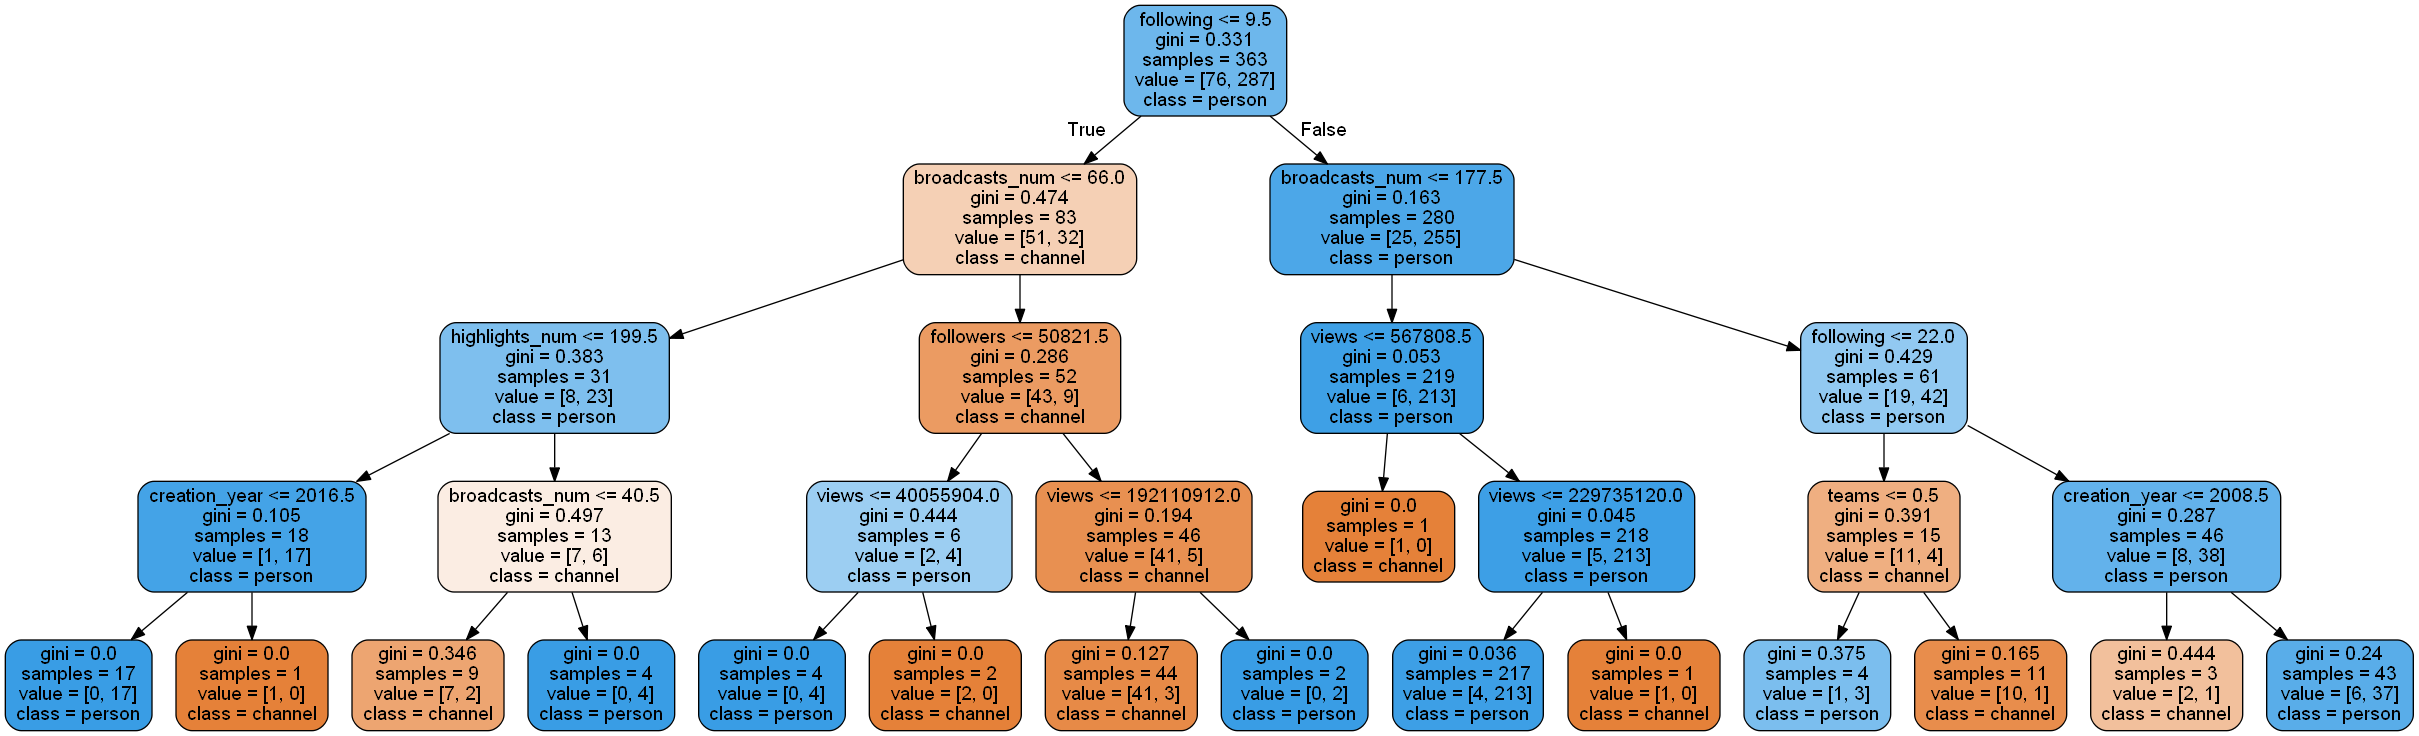

Итоговое дерево получилось богатым на ответвления. Однако, если присмотреться, некоторые переменные появляются здесь слишком часто.

Что же можно отметить:
1. Количество просмотров определённо может указать нам на тип трансляции и самого канала. В нашем случае, дерево указывает, что у медийных каналов просмотров должно быть больше, чем у обычных игровых. Здесь же можно вспомнить о популярности киберспорта: подобные турниры могут одновременно просматриваться *сотнями тысяч* зрителей (и это на одном лишь канале). Помимо этого, зрители также любят чувствовать себя частью толпы, но это уже немного другая часть исследований онлайн трансляций;
2. Количество подписок на канале также появляется в модеил часто. Собственно, здесь всё просто: канал не индивидуальный -> никто не сможет с него подписаться на кого-либо (и просто не увидит смысла);
3. Удивительно, но год создания канала может быть важен, но здесь уже всё будет зависеть от контекста;
4. Переменная, которая выделяется как наименее  сильно делящая категории – число записей трансляции. Под ней предполагается, что на медиа-каналах таких записей будет больше, однако, деление не слишком категоричное.

### Заключение

В общем и целом, (~~хоть и были опасения насчёт результатов~~) полученная модель смогла сделать неплохие предсказания, а также предложить немного идей, добавив исследовательскому вопросу немного больше смысла.
В самом начале отчёта предполагалось, что полезность исследования может быть найдёна в двух сферах (прикладной и исследовательской). Можно попытаться сгруппировать результаты и отметить, что же модель в итоге принесла и тем, и тем:
1. В принципе, весь отчёт показал, что, хоть разработчиками сервиса не делается чёткое разделение между типами каналов, они всё-таки ощутимо. Аудитория твича склонна посещать более традиционные трансляции куда активнее и чаще, а сами же владельцы таких каналов используют их как площадку для ведения трансляций и содержания их в порядке и в полном доступе (большее количество сохранённых записей, меньшее количество подписок). Подобные результаты могли бы помочь сотрудникам сервиса в организации пространства: к примеру, сервис действительно мог бы предоставить пользователям полноценный вариант телевидения и, с другой стороны, контакта с другими игроками (стримеры-любители) более комфортно, чётко разделив каналы, облегчая этим поиск интересующего контента; 
2. С другой стороны, с исследовательской точки зрения стал любопытен тот факт, что, в то время как количество просмотров канала показывает грань между типами стримов, информация о количестве подписчиков не несёт никакой пользы (хотя предполагалось иначе). Результаты показали не совсем очевидную разницу в организации деятельности на каналах, которую вполне можно было бы развить и дальше.